In [1]:
import pandas as pd
import numpy as np

import re

from matplotlib import colors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import geopandas as gpd
import folium

from shapely.geometry import polygon, multipolygon, Point

import mapclassify as mc
import libpysal as lp

from esda import moran # Morans
from splot.esda import plot_moran, moran_scatterplot

## Load District boundaries

In [6]:
venue_population_gdf = gpd.read_file('data/Bangkok-saturated-districts.shp')
# districts_pop_gdf = districts_pop_gdf[['district','population','']]
# districts_pop_gdf.columns = ['district','population','area_sqkm','population_density','geometry']
venue_population_gdf.head()

,district,population,venue_valu,num_venues,venues_per,venue_va_1,lag_venue_,p_value,z_score,geometry
0,Ban Na,64323.0,108.50,299,0.004648,0.001687,0.001104,0.227,0.705342,"POLYGON ((101.06481 14.41179, 101.06536 14.410..."
1,Ban Pho,45252.0,107.00,282,0.006232,0.002365,0.001962,0.342,0.008574,"POLYGON ((100.96163 13.70401, 100.96242 13.703..."
2,Bang Bo,105742.0,116.50,307,0.002903,0.001102,0.001669,0.391,0.461579,"POLYGON ((100.93635 13.66819, 100.93792 13.667..."
3,Bang Bon,138698.0,65.75,104,0.000750,0.000474,0.000674,0.003,1.697114,"POLYGON ((100.43022 13.67181, 100.42820 13.669..."
4,Bang Bua Thong,256290.0,451.50,1094,0.004269,0.001762,0.001404,0.280,0.667541,"POLYGON ((100.38375 13.98669, 100.38609 13.986..."


## Venue Value per Capita per District - Global Morans

In [7]:
# Global autocorrelation test - is the distribution of food venues random?

wq = lp.weights.Queen.from_dataframe(venue_population_gdf, idVariable='district')
wq.transform = 'r'

In [9]:
# Compute spatial lag - the weighted average of food venue value per capita per district
# The spatial leg standardizes the rows and takes the average value of the price in each district.

y = venue_population_gdf['num_venues']
ylag = lp.weights.lag_spatial(wq, y)
ylag[0:5]

array([191.66666667, 739.66666667, 898.14285714, 499.28571429,
       809.4       ])

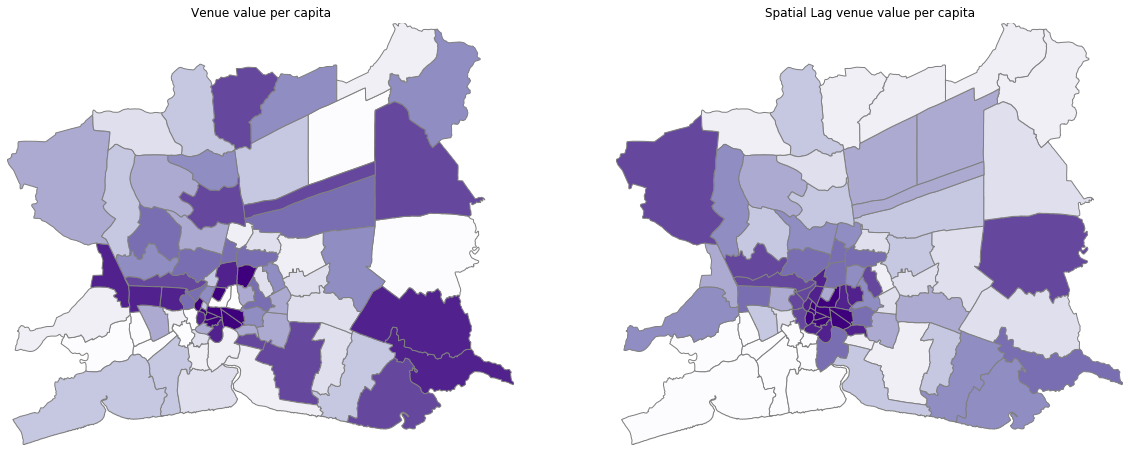

In [199]:
venue_population_gdf['lag_venue_value'] = ylag #make this _gdf
f,ax = plt.subplots(1,2,figsize=(20,10))

venue_population_gdf.plot(column='venue_value_per_capita', ax=ax[0], edgecolor='grey',
        scheme="quantiles",  k=10, cmap='Purples')
ax[0].axis(venue_population_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Venue value per capita")

venue_population_gdf.plot(column='lag_venue_value_per_capita', ax=ax[1], edgecolor='grey',
        scheme='quantiles', cmap='Purples', k=10)
ax[1].axis(venue_population_gdf.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag venue value per capita")
ax[0].axis('off')
ax[1].axis('off')

plt.show()

Text(0.5, 0, "Moran's I")

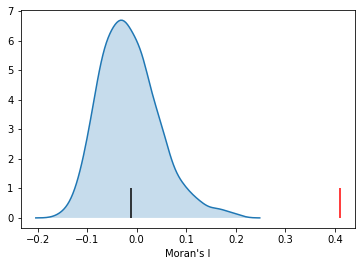

In [208]:
np.random.seed(123)
mi = moran.Moran(y, wq)

sns.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [209]:
# A p-value of 0.05 and less is significant
mi.p_sim

0.001

In [245]:
# Globally, distribution is statistically significant. 
# We reject our null hypothesis that venue distribution is random.

## Local Autocorrelation

In [217]:
li = moran.Moran_Local(y, wq)

# Determine number of statistically-significant hotspots/coldspots
print('Num clusters/outliers: ', (li.p_sim < 0.05).sum())

Num clusters/outliers:  17


(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a3272a8d0>)

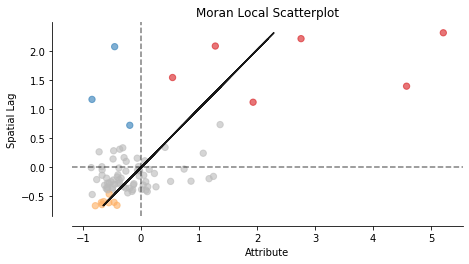

In [219]:
moran_scatterplot(li, p=0.05)

In [220]:
sig = 1 * (li.p_sim < 0.05)

hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)

spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3,
       0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 3, 0, 2, 0, 0, 3, 2,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0])

In [221]:
spot_labels = ['0 not significant', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

In [222]:
venue_population_gdf.loc[:,'cluster_category'] = labels
venue_population_gdf.loc[:,'p_value'] = li.p_sim
venue_population_gdf.loc[:,'z_score'] = li.z_sim
venue_population_gdf.loc[:,'cluster_category'] = venue_population_gdf['cluster_category'].astype('category')
venue_population_gdf.head()

,district,geometry,population,venue_value_sum,num_venues,venues_per_capita,venue_value_per_capita,lag_venue_value_per_capita,cluster_category,p_value,z_score
0,Ban Na,"POLYGON ((101.06481 14.41179, 101.06536 14.410...",64323.0,108.50,299,0.004648,0.001687,0.001104,0 not significant,0.227,0.705342
1,Ban Pho,"POLYGON ((100.96163 13.70401, 100.96242 13.703...",45252.0,107.00,282,0.006232,0.002365,0.001962,0 not significant,0.342,0.008574
2,Bang Bo,"POLYGON ((100.93635 13.66819, 100.93792 13.667...",105742.0,116.50,307,0.002903,0.001102,0.001669,0 not significant,0.391,0.461579
3,Bang Bon,"POLYGON ((100.43022 13.67181, 100.42820 13.669...",138698.0,65.75,104,0.000750,0.000474,0.000674,3 cold spot,0.003,1.697114
4,Bang Bua Thong,"POLYGON ((100.38375 13.98669, 100.38609 13.986...",256290.0,451.50,1094,0.004269,0.001762,0.001404,0 not significant,0.280,0.667541


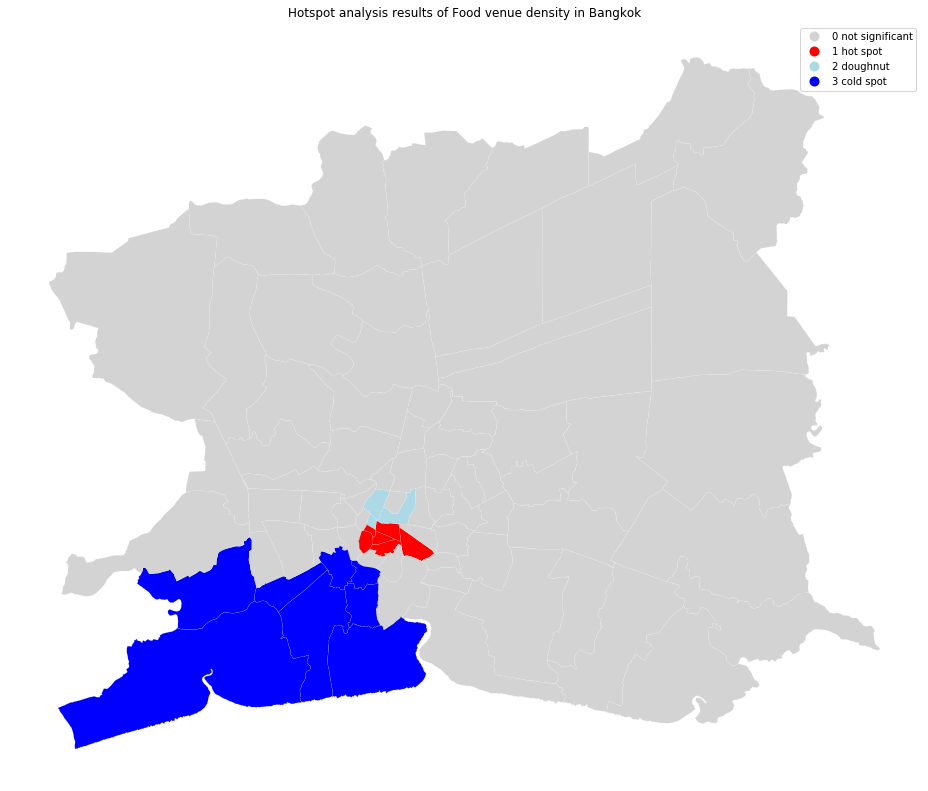

In [223]:
hmap = colors.ListedColormap(['lightgrey', 'red', 'lightblue', 'blue']) # 'pink' for diamonds excluded with zero data points
f, ax = plt.subplots(1, figsize=(20, 14))

venue_population_gdf.plot(column='cluster_category', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()

# venue_population_gdf.apply(lambda x:\
#                          ax.annotate(s=x.district, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

plt.title('Hotspot analysis results of Food venue density in Bangkok')
plt.show()

In [224]:
# Print Doughnut neighbourhoods in order of significance
venue_population_gdf[venue_population_gdf.cluster_category=='2 doughnut'][['district', 'p_value']]\
    .sort_values('p_value')

,district,p_value
61,Pom Pram Sattru,0.003
65,Ratchathewi | Din Dang,0.007
28,Dusit,0.048


In [ ]:
# Moran's I identifies 3 statistically-significant regions as opportunities for food delivery services.

In [225]:
# Print Hot Spot neighbourhoods in order of significance
venue_population_gdf[venue_population_gdf.cluster_category=='1 hot spot'][['district', 'p_value']]\
    .sort_values('p_value')

,district,p_value
17,Bang Rak,0.001
34,Khlong San,0.001
54,Pathum Wan,0.001
72,Sathorn,0.001
70,Samphantawong,0.002
35,Khlong Toey,0.009


In [226]:
# Print Cold Spot neighbourhoods in order of significance
venue_population_gdf[venue_population_gdf.cluster_category=='3 cold spot'][['district', 'p_value']]\
    .sort_values('p_value')

,district,p_value
26,Chom Thong,0.002
36,Krathum Baen,0.002
3,Bang Bon,0.003
21,Bangkhuntien,0.006
77,Thungkru,0.007
48,Muang Samut Sakhon,0.014
59,Phra Samut Jadee,0.015
64,Rat Burana,0.044


In [228]:
venue_population_gdf.reset_index()[['index','district', 'geometry', 'venue_value_per_capita',
       'lag_venue_value_per_capita', 'p_value',
       'z_score']].to_file('data/output-Bangkok.shp')

In [231]:
venue_population_gdf.reset_index()[['index','district', 'population','geometry', 'venue_value_sum', 'venue_value_per_capita',
       'lag_venue_value_per_capita', 'p_value',
       'z_score']].to_file('data/output-Bangkok.geojson',driver="GeoJSON")